In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from skimage import io

from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

import sys
sys.path.append("../../src/features")

from gen_train_val_crops import gen_train_area_mask, gen_crops_from_scene

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
root_dir = "../../data/cowc/datasets/ground_truth_sets"
city = "Utah_AGRC"
data_dir = os.path.join(root_dir, city)

image_basename = "12TVL240120"

image_path = os.path.join(data_dir, image_basename + ".png")
car_label_path = os.path.join(data_dir, image_basename + "_Annotated_Cars.png")
neg_label_path = os.path.join(data_dir, image_basename +  "_Annotated_Negatives.png")

image = io.imread(image_path)
image = image[:, :, :3] # remove alpha channel

label_car = io.imread(car_label_path)
label_car = label_car[:, :, 3] # remove alpha channel

label_neg = io.imread(neg_label_path)
label_neg = label_neg[:, :, 3] # remove alpha channel

In [3]:
def colorize(label_image, labels=(0, 1), colors=([255, 0, 0], [0, 0, 255])):
    
    h, w = label_image.shape
    
    colorized = np.zeros(shape=[h, w, 3], dtype=np.uint8)
             
    for (label, color) in zip(labels, colors):
        colorized[label_image == label] = np.array(color)
    
    return colorized

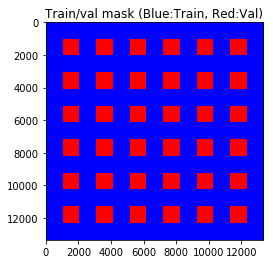

In [4]:
grid_size = 2048

h, w, _ = image.shape
train_area_mask = gen_train_area_mask(h, w, grid_size)

train_val_mask = colorize(train_area_mask)
plt.imshow(train_val_mask)
plt.title("Train/val mask (Blue:Train, Red:Val)")
plt.show()

In [5]:
crop_size = 128

_, _, train_centers, val_centers = \
gen_crops_from_scene(image, label_car, label_neg, train_area_mask, out_basename=None, out_dir=None, crop_size=crop_size, seed=0)

100%|██████████| 26081/26081 [00:20<00:00, 1298.18it/s]


In [6]:
def visualize_crop_footprints(h, w, crop_centers, crop_size):
    
    crop_footprint = np.zeros(shape=[h, w], dtype=bool)
    
    for crop_center in tqdm(crop_centers):

        y, x = crop_center

        top = y - crop_size // 2
        left = x - crop_size // 2
        bottom = top + crop_size
        right = left + crop_size
        
        crop_footprint[top:bottom, left:right] = True
    
    return crop_footprint

100%|██████████| 4896/4896 [00:00<00:00, 53949.01it/s]


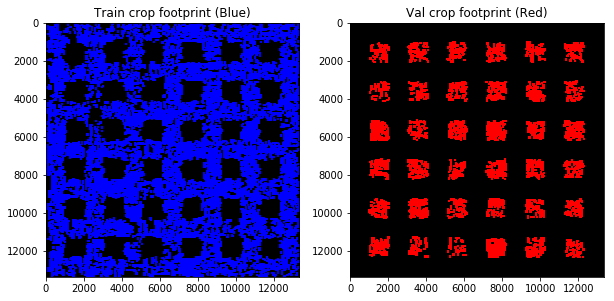

In [7]:
train_crop_footprint = visualize_crop_footprints(h, w, train_centers, crop_size)
val_crop_footprint = visualize_crop_footprints(h, w, val_centers, crop_size)

train_footprint = colorize(train_crop_footprint, labels=(1,), colors=([0, 0, 255],))
val_footprint = colorize(val_crop_footprint, labels=(1,), colors=([255, 0, 0],))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

ax0.imshow(train_footprint)
ax0.set_title('Train crop footprint (Blue)')
ax1.imshow(val_footprint)
ax1.set_title('Val crop footprint (Red)')
plt.show()